# Evaluation

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.csv_generator import CSVGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import pickle

Using TensorFlow backend.
/home/appsyoon/miniconda3/envs/capstone/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Loss

This model has two loss functions. One for the classification subnet, the other for the bounding box regression subnet.

Plot the total, regression and classification losses with validation and save figs.

In [2]:
def plot_loss_history(history_path):
    with (open(history_path, 'rb')) as file:
        history = pickle.load(file)
    
    # get the history file name for savefig
    title, _ = os.path.splitext(history_path)
    
    # validation losses
    val_loss = history['val_loss']
    val_regression_loss = history['val_regression_loss']
    val_classification_loss = history['val_classification_loss']

    # training losses
    loss = history['loss']
    regression_loss = history['regression_loss']
    classification_loss = history['classification_loss']

    plt.title('Loss')
    plt.plot(val_loss, 'r', loss, 'b')
    plt.savefig(title + '_loss.png')
    plt.show()

    plt.title('Classification Loss')
    plt.plot(val_classification_loss, 'r', regression_loss, 'b')
    plt.savefig(title + '_cl_loss.png')
    plt.show()

    plt.title('Regression Loss')
    plt.plot(val_regression_loss, 'r', regression_loss, 'b')
    plt.savefig(title + '_reg_loss.png')
    plt.show()

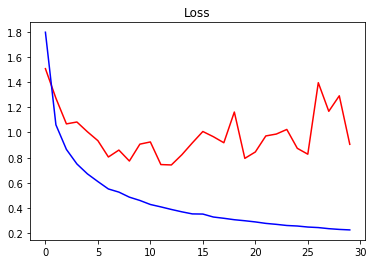

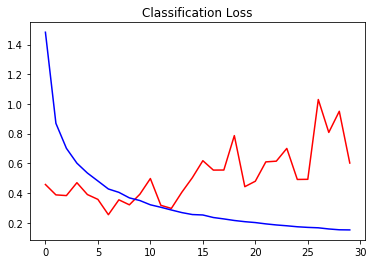

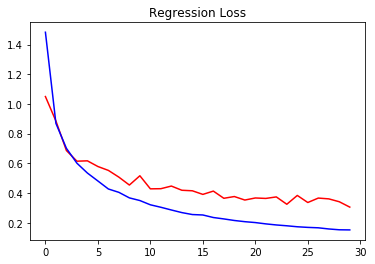

In [3]:
plot_loss_history('history_30_5000.pkl')

## AP/AR

This section loads the trained model and creates a submission text file for the VIVA Hand Detection Challenge evaluation kit to evaluate.

In [4]:
model = keras.models.load_model('./snapshots/e30s5000/resnet50_csv_30.h5', custom_objects=custom_objects)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

/home/appsyoon/miniconda3/envs/capstone/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
test_generator = keras.preprocessing.image.ImageDataGenerator()
csv_test_generator = CSVGenerator(
    './data/test.csv',
    './data/classes.csv',
    test_generator,
    batch_size=1,
)

In [6]:
def get_detections_for_image(image, model, generator):
    # preprocess image for network
    image = csv_test_generator.preprocess_image(image)
    image, scale = csv_test_generator.resize_image(image)

    # process image
    start = time.time()
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    detections[0, :, :4] /= scale
    
    return detections

Test prediction on a random image.

processing time:  3.80678653717041


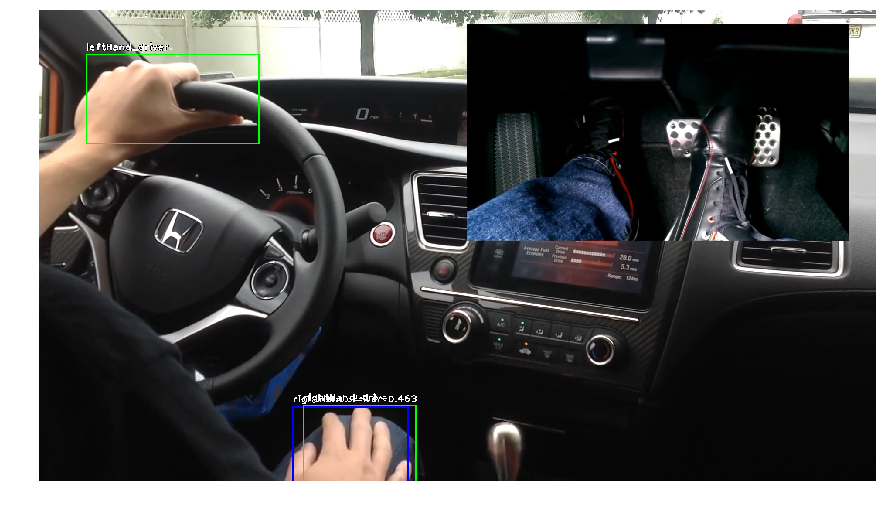

In [7]:
from random import randint

test_index = randint(0,csv_test_generator.size())
# load image
image = csv_test_generator.load_image(test_index)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
detections = get_detections_for_image(image, model, csv_test_generator)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.25:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(csv_test_generator.label_to_name(label), score)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)

annotations = csv_test_generator.load_annotations(test_index)

# visualize annotations
for annotation in annotations:
    label = int(annotation[4])
    b = annotation[:4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
    caption = "{}".format(csv_test_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

A single detection example:

In [ ]:
print(detections[0,100,:])

[ -4.10521240e+01   9.07591980e+02   2.27374100e+02   1.07874609e+03
   3.52651696e-04   1.00467331e-03   1.07439689e-03   3.64210369e-04]


In [ ]:
entries = []

for index in range(csv_test_generator.size()):
    # load image
    image = csv_test_generator.load_image(index)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = csv_test_generator.preprocess_image(image)
    image, scale = csv_test_generator.resize_image(image)
    annotations = csv_test_generator.load_annotations(index)

    # process image
    start = time.time()
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

    # correct for image scale
    detections[0, :, :4] /= scale

    # visualize detections
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        if score < 0.25:
            continue
        _, filename = os.path.split(csv_test_generator.image_path(index))
        filename, _ = os.path.splitext(filename)
        
        b = detections[0, idx, :4].astype(int)
        
        if b[0] < b[2]:
            x, y, w, h = float(b[0]), float(b[1]), float(b[2]-b[0]), float(b[3]-b[1])
        else:
            x, y, w, h = float(b[1]), float(b[0]), float(b[0]-b[2]), float(b[1]-b[3])
            
        entry = '{} {} {} {} {} {} -1 -1 -1'.format(filename, x, y, w, h, score)
        print(entry)
        entries.append(entry)

print('Found {} entries.'.format(len(entries)))
submission = '\n'.join(entries)
with open('submission.txt', 'w') as file:
    file.write(submission)

processing time:  3.120532512664795
processing time:  2.9585883617401123
processing time:  2.9183104038238525
processing time:  3.058117151260376
processing time:  3.078105926513672
processing time:  3.3075857162475586
processing time:  2.9855761528015137
processing time:  2.9587321281433105
processing time:  2.9337265491485596
processing time:  2.9833335876464844
processing time:  2.9313571453094482
10L_0015711_Q_1_4_5 476.0 353.0 73.0 68.0 0.27302423119544983 -1 -1 -1
processing time:  2.9761080741882324
10L_0015712_Q_1_4_5 476.0 353.0 73.0 67.0 0.25131863355636597 -1 -1 -1
processing time:  2.9409708976745605
10L_0015714_Q_1_4_5 476.0 353.0 73.0 68.0 0.2835507094860077 -1 -1 -1
processing time:  2.9337213039398193
10L_0015715_Q_1_4_5 476.0 353.0 73.0 68.0 0.2508409321308136 -1 -1 -1
processing time:  2.925339698791504
10L_0015717_Q_1_4_5 476.0 353.0 73.0 68.0 0.2599794566631317 -1 -1 -1
processing time:  2.926301956176758
processing time:  2.934668779373169
processing time:  2.92600

processing time:  2.926765203475952
10L_0015809_Q_1_4_5 476.0 351.0 73.0 70.0 0.33765190839767456 -1 -1 -1
10L_0015809_Q_1_4_5 269.0 288.0 52.0 76.0 0.30038851499557495 -1 -1 -1
processing time:  2.9194133281707764
10L_0015812_Q_1_4_5 277.0 302.0 48.0 57.0 0.5073398351669312 -1 -1 -1
10L_0015812_Q_1_4_5 476.0 351.0 73.0 69.0 0.30304571986198425 -1 -1 -1
processing time:  2.932234764099121
10L_0015813_Q_1_4_5 477.0 351.0 71.0 69.0 0.3139598071575165 -1 -1 -1
10L_0015813_Q_1_4_5 277.0 307.0 44.0 57.0 0.2936133146286011 -1 -1 -1
processing time:  2.934577226638794
10L_0015814_Q_1_4_5 476.0 351.0 72.0 69.0 0.3067190647125244 -1 -1 -1
10L_0015814_Q_1_4_5 278.0 305.0 43.0 59.0 0.2858741581439972 -1 -1 -1
processing time:  2.923177719116211
10L_0015816_Q_1_4_5 476.0 351.0 71.0 69.0 0.2974441945552826 -1 -1 -1
processing time:  2.933004140853882
processing time:  2.9288411140441895
processing time:  2.928184986114502
10L_0015820_Q_1_4_5 477.0 351.0 71.0 70.0 0.25133103132247925 -1 -1 -1
proces

processing time:  2.9395358562469482
10L_0015898_Q_1_4_5 365.0 316.0 54.0 83.0 0.2980194091796875 -1 -1 -1
10L_0015898_Q_1_4_5 477.0 353.0 71.0 67.0 0.26085782051086426 -1 -1 -1
processing time:  2.9167256355285645
10L_0015900_Q_1_4_5 366.0 313.0 56.0 86.0 0.27450910210609436 -1 -1 -1
10L_0015900_Q_1_4_5 477.0 352.0 73.0 69.0 0.2567408084869385 -1 -1 -1
processing time:  2.9316701889038086
10L_0015901_Q_1_4_5 367.0 314.0 56.0 84.0 0.40895381569862366 -1 -1 -1
10L_0015901_Q_1_4_5 476.0 353.0 74.0 69.0 0.2616613507270813 -1 -1 -1
processing time:  2.9318909645080566
10L_0015902_Q_1_4_5 368.0 314.0 53.0 83.0 0.4075891971588135 -1 -1 -1
10L_0015902_Q_1_4_5 476.0 352.0 74.0 70.0 0.2533845007419586 -1 -1 -1
processing time:  2.915177345275879
10L_0015903_Q_1_4_5 367.0 313.0 54.0 85.0 0.46207869052886963 -1 -1 -1
processing time:  2.9145901203155518
10L_0015904_Q_1_4_5 370.0 316.0 50.0 77.0 0.3575986921787262 -1 -1 -1
processing time:  2.9145712852478027
10L_0015905_Q_1_4_5 367.0 313.0 53.0 8

processing time:  2.923041820526123
10L_0016062_Q_1_4_5 330.0 215.0 91.0 112.0 0.2626829743385315 -1 -1 -1
processing time:  2.915782928466797
10L_0016064_Q_1_4_5 342.0 209.0 88.0 114.0 0.37780123949050903 -1 -1 -1
processing time:  2.909557580947876
10L_0016065_Q_1_4_5 344.0 207.0 88.0 114.0 0.32505035400390625 -1 -1 -1
processing time:  2.927766799926758
10L_0016066_Q_1_4_5 340.0 208.0 90.0 117.0 0.30326318740844727 -1 -1 -1
processing time:  2.9094696044921875
10L_0016067_Q_1_4_5 340.0 207.0 89.0 118.0 0.3614281117916107 -1 -1 -1
processing time:  2.9117116928100586
10L_0016068_Q_1_4_5 340.0 208.0 90.0 117.0 0.38378146290779114 -1 -1 -1
processing time:  2.9286715984344482
10L_0016069_Q_1_4_5 341.0 208.0 90.0 115.0 0.3983248472213745 -1 -1 -1
processing time:  2.915098190307617
10L_0016070_Q_1_4_5 341.0 207.0 90.0 117.0 0.4375779926776886 -1 -1 -1
processing time:  2.910186290740967
10L_0016071_Q_1_4_5 342.0 208.0 90.0 117.0 0.459513783454895 -1 -1 -1
processing time:  2.90766406059

processing time:  2.9382200241088867
processing time:  2.914921760559082
10L_0016180_Q_1_4_5 312.0 210.0 86.0 120.0 0.30174383521080017 -1 -1 -1
processing time:  2.924530506134033
10L_0016181_Q_1_4_5 270.0 218.0 82.0 117.0 0.7151826620101929 -1 -1 -1
processing time:  2.9181344509124756
10L_0016183_Q_1_4_5 225.0 232.0 84.0 109.0 0.3840923011302948 -1 -1 -1
processing time:  2.9168202877044678
processing time:  2.9075660705566406
processing time:  2.9205284118652344
processing time:  2.9267542362213135
processing time:  2.9229865074157715
processing time:  2.914055109024048
processing time:  2.9211790561676025
processing time:  2.923123359680176
processing time:  2.927417755126953
processing time:  2.9228107929229736
processing time:  2.931812047958374
processing time:  2.9099948406219482
processing time:  2.914548635482788
processing time:  2.9108259677886963
processing time:  2.9112942218780518
processing time:  2.9176695346832275
processing time:  2.917802333831787
processing time: 

processing time:  3.6793107986450195
14_0000205_0_0_0_3 980.0 896.0 211.0 194.0 0.3454599678516388 -1 -1 -1
processing time:  3.5657620429992676
14_0000206_0_0_0_3 978.0 895.0 212.0 196.0 0.36573028564453125 -1 -1 -1
processing time:  3.582674026489258
14_0000207_0_0_0_3 977.0 891.0 211.0 201.0 0.2980128526687622 -1 -1 -1
14_0000207_0_0_0_3 110.0 92.0 392.0 226.0 0.26685643196105957 -1 -1 -1
processing time:  3.5850422382354736
14_0000208_0_0_0_3 103.0 92.0 393.0 227.0 0.2587778866291046 -1 -1 -1
processing time:  3.593496322631836
14_0000209_0_0_0_3 85.0 90.0 398.0 237.0 0.29428529739379883 -1 -1 -1
processing time:  3.5759084224700928
14_0000210_0_0_0_3 86.0 90.0 399.0 237.0 0.2817193269729614 -1 -1 -1
processing time:  3.578569173812866
14_0000211_0_0_0_3 83.0 89.0 399.0 238.0 0.26707327365875244 -1 -1 -1
processing time:  3.576636791229248
14_0000212_0_0_0_3 942.0 898.0 261.0 199.0 0.3443552851676941 -1 -1 -1
14_0000212_0_0_0_3 83.0 91.0 404.0 238.0 0.25497323274612427 -1 -1 -1
pro

processing time:  3.586909532546997
14_0000332_0_0_0_3 935.0 926.0 244.0 159.0 0.4724544286727905 -1 -1 -1
14_0000332_0_0_0_3 54.0 95.0 375.0 233.0 0.30219221115112305 -1 -1 -1
processing time:  3.5700948238372803
14_0000333_0_0_0_3 965.0 921.0 252.0 163.0 0.46767136454582214 -1 -1 -1
14_0000333_0_0_0_3 55.0 97.0 376.0 229.0 0.3322886526584625 -1 -1 -1
processing time:  3.586233139038086
14_0000334_0_0_0_3 972.0 918.0 265.0 168.0 0.48695409297943115 -1 -1 -1
14_0000334_0_0_0_3 53.0 97.0 377.0 229.0 0.2829224169254303 -1 -1 -1
processing time:  3.5800318717956543
14_0000335_0_0_0_3 948.0 908.0 283.0 180.0 0.4812038242816925 -1 -1 -1
14_0000335_0_0_0_3 49.0 98.0 383.0 228.0 0.3048207759857178 -1 -1 -1
processing time:  3.607330322265625
14_0000336_0_0_0_3 869.0 907.0 294.0 187.0 0.3941797912120819 -1 -1 -1
14_0000336_0_0_0_3 54.0 97.0 377.0 223.0 0.2771996557712555 -1 -1 -1
processing time:  3.612475633621216
14_0000337_0_0_0_3 870.0 907.0 293.0 187.0 0.3899349868297577 -1 -1 -1
14_00003

processing time:  3.5589869022369385
14_0001761_0_0_0_3 916.0 576.0 249.0 274.0 0.5415914058685303 -1 -1 -1
processing time:  3.571239471435547
14_0001762_0_0_0_3 914.0 572.0 249.0 276.0 0.528782844543457 -1 -1 -1
processing time:  3.577332019805908
14_0001763_0_0_0_3 908.0 573.0 247.0 284.0 0.49555322527885437 -1 -1 -1
processing time:  3.574398994445801
14_0001764_0_0_0_3 903.0 576.0 243.0 288.0 0.4829607605934143 -1 -1 -1
processing time:  3.5645949840545654
14_0001765_0_0_0_3 888.0 577.0 246.0 282.0 0.5807409286499023 -1 -1 -1
processing time:  3.569129705429077
14_0001766_0_0_0_3 874.0 585.0 255.0 284.0 0.34753063321113586 -1 -1 -1
processing time:  3.5710930824279785
14_0001769_0_0_0_3 791.0 598.0 272.0 270.0 0.45787304639816284 -1 -1 -1
processing time:  3.5790059566497803
14_0001770_0_0_0_3 776.0 596.0 270.0 276.0 0.6508227586746216 -1 -1 -1
processing time:  3.5651590824127197
14_0001771_0_0_0_3 756.0 595.0 272.0 277.0 0.5895460844039917 -1 -1 -1
processing time:  3.5703616142

processing time:  3.5669867992401123
19_0002082_0_0_0_6 384.0 518.0 132.0 158.0 0.4970890283584595 -1 -1 -1
processing time:  3.5621399879455566
19_0002083_0_0_0_6 378.0 512.0 139.0 161.0 0.5584917068481445 -1 -1 -1
processing time:  3.5870485305786133
19_0002084_0_0_0_6 367.0 504.0 141.0 160.0 0.6221444010734558 -1 -1 -1
processing time:  3.601667881011963
19_0002086_0_0_0_6 356.0 482.0 146.0 167.0 0.3439783453941345 -1 -1 -1
processing time:  3.5737311840057373
19_0002087_0_0_0_6 353.0 494.0 146.0 171.0 0.5577581524848938 -1 -1 -1
processing time:  3.56974458694458
19_0002088_0_0_0_6 359.0 517.0 144.0 163.0 0.47098255157470703 -1 -1 -1
processing time:  3.587015390396118
19_0002090_0_0_0_6 359.0 534.0 144.0 167.0 0.6396822929382324 -1 -1 -1
processing time:  3.5758445262908936
19_0002093_0_0_0_6 367.0 515.0 134.0 163.0 0.5869388580322266 -1 -1 -1
processing time:  3.5639336109161377
19_0002095_0_0_0_6 366.0 517.0 132.0 160.0 0.4634997844696045 -1 -1 -1
processing time:  3.57249903678

processing time:  2.914459466934204
1L_0012917_Q_6_2_5 485.0 356.0 93.0 72.0 0.4648163616657257 -1 -1 -1
1L_0012917_Q_6_2_5 49.0 301.0 79.0 58.0 0.4399603605270386 -1 -1 -1
1L_0012917_Q_6_2_5 154.0 268.0 136.0 91.0 0.41732457280158997 -1 -1 -1
1L_0012917_Q_6_2_5 563.0 317.0 71.0 67.0 0.3514992892742157 -1 -1 -1
processing time:  2.918933391571045
1L_0012918_Q_6_2_5 485.0 356.0 93.0 72.0 0.45869120955467224 -1 -1 -1
1L_0012918_Q_6_2_5 50.0 301.0 79.0 57.0 0.4421469271183014 -1 -1 -1
1L_0012918_Q_6_2_5 152.0 268.0 137.0 91.0 0.4145994186401367 -1 -1 -1
1L_0012918_Q_6_2_5 563.0 317.0 71.0 68.0 0.3409416973590851 -1 -1 -1
processing time:  2.923395872116089
1L_0012919_Q_6_2_5 485.0 356.0 93.0 72.0 0.4563802182674408 -1 -1 -1
1L_0012919_Q_6_2_5 52.0 302.0 77.0 57.0 0.43362727761268616 -1 -1 -1
1L_0012919_Q_6_2_5 151.0 268.0 137.0 90.0 0.4157298505306244 -1 -1 -1
1L_0012919_Q_6_2_5 564.0 317.0 70.0 67.0 0.35821732878685 -1 -1 -1
processing time:  2.9324755668640137
1L_0012920_Q_6_2_5 485.0 3

processing time:  2.924765110015869
1L_0012950_Q_6_2_5 87.0 309.0 70.0 51.0 0.606232762336731 -1 -1 -1
1L_0012950_Q_6_2_5 84.0 252.0 169.0 101.0 0.48597630858421326 -1 -1 -1
1L_0012950_Q_6_2_5 486.0 356.0 93.0 72.0 0.454386830329895 -1 -1 -1
1L_0012950_Q_6_2_5 566.0 317.0 66.0 67.0 0.4146907329559326 -1 -1 -1
processing time:  2.9176883697509766
1L_0012998_Q_6_2_5 204.0 278.0 89.0 80.0 0.49877265095710754 -1 -1 -1
1L_0012998_Q_6_2_5 483.0 356.0 94.0 72.0 0.46244001388549805 -1 -1 -1
1L_0012998_Q_6_2_5 125.0 319.0 71.0 47.0 0.4622921943664551 -1 -1 -1
1L_0012998_Q_6_2_5 564.0 318.0 67.0 67.0 0.3748777508735657 -1 -1 -1
processing time:  2.9088096618652344
1L_0012999_Q_6_2_5 484.0 356.0 93.0 72.0 0.4717658758163452 -1 -1 -1
1L_0012999_Q_6_2_5 208.0 280.0 90.0 78.0 0.4248476028442383 -1 -1 -1
1L_0012999_Q_6_2_5 129.0 320.0 73.0 46.0 0.3880414068698883 -1 -1 -1
1L_0012999_Q_6_2_5 563.0 318.0 68.0 67.0 0.34935590624809265 -1 -1 -1
processing time:  2.923708200454712
1L_0013000_Q_6_2_5 216.0

processing time:  2.939000368118286
1L_0013033_Q_6_2_5 133.0 264.0 140.0 98.0 0.5032280087471008 -1 -1 -1
1L_0013033_Q_6_2_5 473.0 356.0 91.0 72.0 0.4685424566268921 -1 -1 -1
1L_0013033_Q_6_2_5 259.0 310.0 40.0 56.0 0.3959234356880188 -1 -1 -1
1L_0013033_Q_6_2_5 548.0 320.0 77.0 69.0 0.3826849162578583 -1 -1 -1
processing time:  2.910461187362671
1L_0013034_Q_6_2_5 155.0 268.0 128.0 96.0 0.4924577474594116 -1 -1 -1
1L_0013034_Q_6_2_5 475.0 356.0 92.0 73.0 0.4302828311920166 -1 -1 -1
1L_0013034_Q_6_2_5 549.0 320.0 77.0 69.0 0.3807404041290283 -1 -1 -1
processing time:  2.917985677719116
1L_0013035_Q_6_2_5 163.0 270.0 128.0 94.0 0.46973997354507446 -1 -1 -1
1L_0013035_Q_6_2_5 478.0 357.0 89.0 71.0 0.38407281041145325 -1 -1 -1
1L_0013035_Q_6_2_5 549.0 320.0 77.0 69.0 0.3831464350223541 -1 -1 -1
processing time:  2.9114294052124023
1L_0013036_Q_6_2_5 167.0 270.0 127.0 94.0 0.496473103761673 -1 -1 -1
1L_0013036_Q_6_2_5 550.0 321.0 77.0 68.0 0.3687390685081482 -1 -1 -1
1L_0013036_Q_6_2_5 478

processing time:  2.9225661754608154
1L_0013072_Q_6_2_5 245.0 292.0 66.0 69.0 0.5249080657958984 -1 -1 -1
1L_0013072_Q_6_2_5 479.0 355.0 89.0 70.0 0.42816346883773804 -1 -1 -1
1L_0013072_Q_6_2_5 548.0 322.0 81.0 70.0 0.39220598340034485 -1 -1 -1
processing time:  2.914185047149658
1L_0013073_Q_6_2_5 241.0 290.0 70.0 72.0 0.6073242425918579 -1 -1 -1
1L_0013073_Q_6_2_5 479.0 355.0 88.0 70.0 0.420526385307312 -1 -1 -1
1L_0013073_Q_6_2_5 548.0 322.0 80.0 69.0 0.4100678861141205 -1 -1 -1
processing time:  2.9178855419158936
1L_0013074_Q_6_2_5 226.0 283.0 85.0 77.0 0.5321048498153687 -1 -1 -1
1L_0013074_Q_6_2_5 479.0 355.0 88.0 70.0 0.43455561995506287 -1 -1 -1
1L_0013074_Q_6_2_5 548.0 322.0 80.0 69.0 0.4117354452610016 -1 -1 -1
processing time:  2.903348922729492
1L_0013075_Q_6_2_5 221.0 280.0 87.0 82.0 0.6638580560684204 -1 -1 -1
1L_0013075_Q_6_2_5 479.0 355.0 88.0 70.0 0.44022953510284424 -1 -1 -1
1L_0013075_Q_6_2_5 548.0 322.0 80.0 69.0 0.41351625323295593 -1 -1 -1
processing time:  2.91

processing time:  2.9491124153137207
1L_0013126_Q_6_2_5 554.0 322.0 77.0 69.0 0.4326719343662262 -1 -1 -1
1L_0013126_Q_6_2_5 27.0 300.0 86.0 55.0 0.30068981647491455 -1 -1 -1
1L_0013126_Q_6_2_5 237.0 274.0 73.0 81.0 0.28711238503456116 -1 -1 -1
processing time:  2.924070358276367
1L_0013128_Q_6_2_5 553.0 322.0 77.0 69.0 0.4218637943267822 -1 -1 -1
1L_0013128_Q_6_2_5 27.0 301.0 86.0 53.0 0.25860875844955444 -1 -1 -1
processing time:  2.9254438877105713
1L_0013129_Q_6_2_5 554.0 322.0 75.0 69.0 0.43923816084861755 -1 -1 -1
1L_0013129_Q_6_2_5 231.0 272.0 77.0 86.0 0.43681102991104126 -1 -1 -1
1L_0013129_Q_6_2_5 32.0 302.0 86.0 51.0 0.27295902371406555 -1 -1 -1
processing time:  2.9193146228790283
1L_0013131_Q_6_2_5 228.0 271.0 79.0 83.0 0.5267435908317566 -1 -1 -1
1L_0013131_Q_6_2_5 554.0 322.0 75.0 69.0 0.453755259513855 -1 -1 -1
1L_0013131_Q_6_2_5 29.0 300.0 87.0 55.0 0.3381197154521942 -1 -1 -1
processing time:  2.9386403560638428
1L_0013133_Q_6_2_5 228.0 271.0 78.0 85.0 0.4993001520633

processing time:  2.910658359527588
1L_0013174_Q_6_2_5 558.0 321.0 74.0 68.0 0.3976566195487976 -1 -1 -1
1L_0013174_Q_6_2_5 75.0 310.0 86.0 48.0 0.33237749338150024 -1 -1 -1
processing time:  2.9204561710357666
1L_0013175_Q_6_2_5 559.0 321.0 74.0 68.0 0.391550213098526 -1 -1 -1
1L_0013175_Q_6_2_5 76.0 310.0 85.0 48.0 0.34550362825393677 -1 -1 -1
processing time:  2.905414581298828
1L_0013176_Q_6_2_5 557.0 321.0 74.0 68.0 0.3940955102443695 -1 -1 -1
1L_0013176_Q_6_2_5 79.0 311.0 84.0 47.0 0.3542424142360687 -1 -1 -1
1L_0013176_Q_6_2_5 257.0 279.0 61.0 82.0 0.2561006546020508 -1 -1 -1
processing time:  2.9160757064819336
1L_0013177_Q_6_2_5 558.0 321.0 73.0 68.0 0.3768162429332733 -1 -1 -1
1L_0013177_Q_6_2_5 255.0 276.0 63.0 82.0 0.31346163153648376 -1 -1 -1
1L_0013177_Q_6_2_5 85.0 311.0 80.0 47.0 0.3011346459388733 -1 -1 -1
processing time:  2.925161600112915
1L_0013178_Q_6_2_5 558.0 321.0 73.0 68.0 0.37933966517448425 -1 -1 -1
1L_0013178_Q_6_2_5 84.0 310.0 82.0 49.0 0.3557398021221161 -

processing time:  2.9315805435180664
1L_0013215_Q_6_2_5 122.0 316.0 61.0 48.0 0.6433809399604797 -1 -1 -1
1L_0013215_Q_6_2_5 557.0 322.0 75.0 67.0 0.5214176177978516 -1 -1 -1
1L_0013215_Q_6_2_5 468.0 355.0 88.0 70.0 0.46720391511917114 -1 -1 -1
1L_0013215_Q_6_2_5 242.0 290.0 73.0 70.0 0.4644682705402374 -1 -1 -1
processing time:  2.9254612922668457
1L_0013216_Q_6_2_5 123.0 316.0 60.0 48.0 0.6120123863220215 -1 -1 -1
1L_0013216_Q_6_2_5 560.0 321.0 71.0 66.0 0.5258661508560181 -1 -1 -1
1L_0013216_Q_6_2_5 468.0 355.0 88.0 70.0 0.47727590799331665 -1 -1 -1
processing time:  2.9145727157592773
1L_0013217_Q_6_2_5 122.0 316.0 60.0 48.0 0.6419652700424194 -1 -1 -1
1L_0013217_Q_6_2_5 244.0 289.0 72.0 71.0 0.5367754697799683 -1 -1 -1
1L_0013217_Q_6_2_5 557.0 321.0 74.0 67.0 0.5267549157142639 -1 -1 -1
1L_0013217_Q_6_2_5 468.0 355.0 88.0 70.0 0.48182201385498047 -1 -1 -1
processing time:  2.922544479370117
1L_0013218_Q_6_2_5 122.0 316.0 60.0 48.0 0.6226295232772827 -1 -1 -1
1L_0013218_Q_6_2_5 559

processing time:  2.9290108680725098
1L_0013249_Q_6_2_5 110.0 314.0 61.0 51.0 0.6110929250717163 -1 -1 -1
1L_0013249_Q_6_2_5 556.0 318.0 77.0 70.0 0.4812564551830292 -1 -1 -1
1L_0013249_Q_6_2_5 465.0 354.0 91.0 72.0 0.4321099817752838 -1 -1 -1
processing time:  2.9142537117004395
1L_0013250_Q_6_2_5 110.0 314.0 61.0 51.0 0.5769990682601929 -1 -1 -1
1L_0013250_Q_6_2_5 466.0 354.0 88.0 71.0 0.4715930223464966 -1 -1 -1
1L_0013250_Q_6_2_5 555.0 318.0 80.0 70.0 0.4625939428806305 -1 -1 -1
processing time:  2.922787666320801
1L_0013251_Q_6_2_5 111.0 313.0 61.0 51.0 0.5492744445800781 -1 -1 -1
1L_0013251_Q_6_2_5 555.0 319.0 79.0 69.0 0.4834418296813965 -1 -1 -1
1L_0013251_Q_6_2_5 466.0 354.0 88.0 71.0 0.4568784534931183 -1 -1 -1
processing time:  2.9063332080841064
1L_0013252_Q_6_2_5 111.0 314.0 60.0 51.0 0.5745357275009155 -1 -1 -1
1L_0013252_Q_6_2_5 466.0 354.0 88.0 71.0 0.4800833761692047 -1 -1 -1
1L_0013252_Q_6_2_5 554.0 320.0 79.0 68.0 0.479735791683197 -1 -1 -1
processing time:  2.917819

processing time:  2.918304920196533
1L_0013282_Q_6_2_5 110.0 314.0 59.0 49.0 0.657796323299408 -1 -1 -1
1L_0013282_Q_6_2_5 246.0 289.0 68.0 72.0 0.561993420124054 -1 -1 -1
1L_0013282_Q_6_2_5 554.0 319.0 72.0 66.0 0.4805677533149719 -1 -1 -1
1L_0013282_Q_6_2_5 466.0 355.0 90.0 71.0 0.4524906873703003 -1 -1 -1
processing time:  2.9141271114349365
1L_0013283_Q_6_2_5 110.0 314.0 59.0 49.0 0.6837049126625061 -1 -1 -1
1L_0013283_Q_6_2_5 246.0 289.0 68.0 72.0 0.558440089225769 -1 -1 -1
1L_0013283_Q_6_2_5 554.0 319.0 72.0 66.0 0.4676528871059418 -1 -1 -1
1L_0013283_Q_6_2_5 466.0 355.0 89.0 71.0 0.4601995646953583 -1 -1 -1
processing time:  2.9167234897613525
1L_0013284_Q_6_2_5 110.0 313.0 62.0 50.0 0.6887305974960327 -1 -1 -1
1L_0013284_Q_6_2_5 247.0 289.0 68.0 72.0 0.5506221055984497 -1 -1 -1
1L_0013284_Q_6_2_5 466.0 355.0 89.0 71.0 0.46249139308929443 -1 -1 -1
1L_0013284_Q_6_2_5 554.0 319.0 72.0 66.0 0.4606262743473053 -1 -1 -1
processing time:  2.916006088256836
1L_0013285_Q_6_2_5 112.0 314

processing time:  2.9325783252716064
1L_0013313_Q_6_2_5 246.0 289.0 69.0 71.0 0.6190610527992249 -1 -1 -1
1L_0013313_Q_6_2_5 36.0 304.0 88.0 56.0 0.4880003035068512 -1 -1 -1
1L_0013313_Q_6_2_5 468.0 353.0 87.0 71.0 0.47304823994636536 -1 -1 -1
1L_0013313_Q_6_2_5 554.0 321.0 77.0 67.0 0.44194573163986206 -1 -1 -1
processing time:  2.916736125946045
1L_0013314_Q_6_2_5 245.0 288.0 70.0 73.0 0.5936647057533264 -1 -1 -1
1L_0013314_Q_6_2_5 36.0 304.0 88.0 56.0 0.48467889428138733 -1 -1 -1
1L_0013314_Q_6_2_5 468.0 353.0 88.0 71.0 0.4609644114971161 -1 -1 -1
1L_0013314_Q_6_2_5 554.0 321.0 77.0 67.0 0.42839324474334717 -1 -1 -1
processing time:  2.921482563018799
1L_0013315_Q_6_2_5 247.0 289.0 68.0 71.0 0.5897759199142456 -1 -1 -1
1L_0013315_Q_6_2_5 468.0 353.0 88.0 71.0 0.4596076011657715 -1 -1 -1
1L_0013315_Q_6_2_5 553.0 321.0 79.0 68.0 0.4551946818828583 -1 -1 -1
1L_0013315_Q_6_2_5 37.0 304.0 89.0 56.0 0.45233651995658875 -1 -1 -1
processing time:  2.9125216007232666
1L_0013316_Q_6_2_5 246.0

processing time:  2.919124126434326
1L_0013344_Q_6_2_5 252.0 287.0 63.0 72.0 0.5310312509536743 -1 -1 -1
1L_0013344_Q_6_2_5 50.0 306.0 84.0 57.0 0.5257043242454529 -1 -1 -1
1L_0013344_Q_6_2_5 467.0 353.0 89.0 71.0 0.47225600481033325 -1 -1 -1
1L_0013344_Q_6_2_5 554.0 320.0 82.0 69.0 0.4562515914440155 -1 -1 -1
processing time:  2.9188072681427
1L_0013345_Q_6_2_5 49.0 305.0 86.0 57.0 0.5450536012649536 -1 -1 -1
1L_0013345_Q_6_2_5 554.0 320.0 80.0 69.0 0.5319852828979492 -1 -1 -1
1L_0013345_Q_6_2_5 253.0 287.0 62.0 73.0 0.5125529766082764 -1 -1 -1
1L_0013345_Q_6_2_5 468.0 353.0 88.0 71.0 0.46291297674179077 -1 -1 -1
processing time:  2.9132463932037354
1L_0013346_Q_6_2_5 49.0 306.0 85.0 56.0 0.5484606027603149 -1 -1 -1
1L_0013346_Q_6_2_5 253.0 288.0 62.0 72.0 0.5262294411659241 -1 -1 -1
1L_0013346_Q_6_2_5 553.0 320.0 81.0 69.0 0.505459189414978 -1 -1 -1
1L_0013346_Q_6_2_5 468.0 353.0 88.0 71.0 0.4686037003993988 -1 -1 -1
processing time:  2.906918525695801
1L_0013348_Q_6_2_5 49.0 306.0 8

processing time:  2.9194374084472656
1L_0013380_Q_6_2_5 252.0 288.0 64.0 71.0 0.5881361365318298 -1 -1 -1
1L_0013380_Q_6_2_5 70.0 310.0 83.0 54.0 0.5168946981430054 -1 -1 -1
1L_0013380_Q_6_2_5 470.0 354.0 88.0 70.0 0.48566803336143494 -1 -1 -1
1L_0013380_Q_6_2_5 557.0 318.0 76.0 68.0 0.4590848684310913 -1 -1 -1
processing time:  2.916757822036743
1L_0013382_Q_6_2_5 253.0 288.0 63.0 71.0 0.5665515661239624 -1 -1 -1
1L_0013382_Q_6_2_5 75.0 307.0 81.0 56.0 0.5279297828674316 -1 -1 -1
1L_0013382_Q_6_2_5 557.0 319.0 79.0 69.0 0.5022295713424683 -1 -1 -1
1L_0013382_Q_6_2_5 470.0 354.0 89.0 70.0 0.47348079085350037 -1 -1 -1
processing time:  2.9233503341674805
1L_0013383_Q_6_2_5 253.0 288.0 63.0 71.0 0.559604823589325 -1 -1 -1
1L_0013383_Q_6_2_5 75.0 308.0 80.0 56.0 0.5482873320579529 -1 -1 -1
1L_0013383_Q_6_2_5 556.0 318.0 80.0 71.0 0.5007838010787964 -1 -1 -1
1L_0013383_Q_6_2_5 470.0 354.0 88.0 69.0 0.4783988893032074 -1 -1 -1
processing time:  2.9078683853149414
1L_0013384_Q_6_2_5 253.0 28

processing time:  2.9124927520751953
1L_0013411_Q_6_2_5 471.0 354.0 89.0 69.0 0.5101721882820129 -1 -1 -1
1L_0013411_Q_6_2_5 86.0 310.0 71.0 53.0 0.49954307079315186 -1 -1 -1
1L_0013411_Q_6_2_5 556.0 319.0 78.0 68.0 0.4907403886318207 -1 -1 -1
1L_0013411_Q_6_2_5 256.0 291.0 59.0 69.0 0.4555180072784424 -1 -1 -1
processing time:  2.938354253768921
1L_0013412_Q_6_2_5 471.0 354.0 89.0 69.0 0.509384274482727 -1 -1 -1
1L_0013412_Q_6_2_5 86.0 310.0 70.0 52.0 0.50663822889328 -1 -1 -1
1L_0013412_Q_6_2_5 557.0 319.0 78.0 69.0 0.48073652386665344 -1 -1 -1
1L_0013412_Q_6_2_5 256.0 291.0 60.0 69.0 0.45134589076042175 -1 -1 -1
processing time:  2.914973258972168
1L_0013413_Q_6_2_5 555.0 319.0 80.0 69.0 0.5101071000099182 -1 -1 -1
1L_0013413_Q_6_2_5 471.0 354.0 89.0 69.0 0.5065841674804688 -1 -1 -1
1L_0013413_Q_6_2_5 86.0 310.0 71.0 52.0 0.492695152759552 -1 -1 -1
1L_0013413_Q_6_2_5 257.0 291.0 58.0 69.0 0.4591159224510193 -1 -1 -1
processing time:  2.9198293685913086
1L_0013414_Q_6_2_5 471.0 354.0

processing time:  2.916256904602051
1L_0013443_Q_6_2_5 69.0 309.0 83.0 54.0 0.6186636090278625 -1 -1 -1
1L_0013443_Q_6_2_5 470.0 354.0 89.0 69.0 0.4918471872806549 -1 -1 -1
1L_0013443_Q_6_2_5 256.0 292.0 59.0 68.0 0.48436400294303894 -1 -1 -1
1L_0013443_Q_6_2_5 557.0 319.0 81.0 70.0 0.47026142477989197 -1 -1 -1
processing time:  2.916692018508911
1L_0013444_Q_6_2_5 70.0 308.0 82.0 55.0 0.5998287796974182 -1 -1 -1
1L_0013444_Q_6_2_5 257.0 292.0 58.0 68.0 0.5037323832511902 -1 -1 -1
1L_0013444_Q_6_2_5 470.0 354.0 89.0 69.0 0.49625328183174133 -1 -1 -1
1L_0013444_Q_6_2_5 557.0 319.0 80.0 70.0 0.4792216420173645 -1 -1 -1
processing time:  2.921337604522705
1L_0013445_Q_6_2_5 72.0 308.0 81.0 55.0 0.5629844069480896 -1 -1 -1
1L_0013445_Q_6_2_5 257.0 292.0 58.0 68.0 0.5073047280311584 -1 -1 -1
1L_0013445_Q_6_2_5 470.0 353.0 89.0 70.0 0.5036178231239319 -1 -1 -1
1L_0013445_Q_6_2_5 556.0 319.0 81.0 70.0 0.4807354211807251 -1 -1 -1
processing time:  2.9256398677825928
1L_0013446_Q_6_2_5 71.0 308

processing time:  2.93172025680542
1L_0013475_Q_6_2_5 259.0 291.0 57.0 71.0 0.5234354734420776 -1 -1 -1
1L_0013475_Q_6_2_5 90.0 309.0 74.0 51.0 0.5168728232383728 -1 -1 -1
1L_0013475_Q_6_2_5 472.0 353.0 88.0 70.0 0.5135973691940308 -1 -1 -1
1L_0013475_Q_6_2_5 558.0 319.0 80.0 69.0 0.478267103433609 -1 -1 -1
processing time:  2.909959316253662
1L_0013476_Q_6_2_5 259.0 291.0 57.0 71.0 0.5240857005119324 -1 -1 -1
1L_0013476_Q_6_2_5 91.0 310.0 72.0 50.0 0.5234246253967285 -1 -1 -1
1L_0013476_Q_6_2_5 472.0 353.0 88.0 70.0 0.5070524215698242 -1 -1 -1
1L_0013476_Q_6_2_5 558.0 320.0 80.0 68.0 0.46688252687454224 -1 -1 -1
processing time:  2.909985303878784
1L_0013477_Q_6_2_5 472.0 353.0 88.0 69.0 0.5396332740783691 -1 -1 -1
1L_0013477_Q_6_2_5 92.0 310.0 72.0 50.0 0.535833477973938 -1 -1 -1
1L_0013477_Q_6_2_5 259.0 290.0 57.0 71.0 0.49515488743782043 -1 -1 -1
1L_0013477_Q_6_2_5 557.0 319.0 81.0 69.0 0.4769276976585388 -1 -1 -1
processing time:  2.9342246055603027
1L_0013478_Q_6_2_5 472.0 353.0 

processing time:  3.6309196949005127
20_0001478_0_0_0_3 666.0 510.0 186.0 218.0 0.5816874504089355 -1 -1 -1
20_0001478_0_0_0_3 241.0 388.0 182.0 220.0 0.4763202369213104 -1 -1 -1
processing time:  3.5888431072235107
20_0001479_0_0_0_3 732.0 553.0 169.0 218.0 0.5919002890586853 -1 -1 -1
20_0001479_0_0_0_3 241.0 401.0 175.0 217.0 0.45970767736434937 -1 -1 -1
processing time:  3.58437180519104
20_0001480_0_0_0_3 755.0 582.0 180.0 208.0 0.5203740000724792 -1 -1 -1
20_0001480_0_0_0_3 244.0 408.0 168.0 217.0 0.46668359637260437 -1 -1 -1
20_0001480_0_0_0_3 1245.0 764.0 289.0 179.0 0.2614562213420868 -1 -1 -1
processing time:  3.582578659057617
20_0001481_0_0_0_3 243.0 405.0 169.0 219.0 0.4763140082359314 -1 -1 -1
20_0001481_0_0_0_3 789.0 611.0 161.0 215.0 0.47397464513778687 -1 -1 -1
20_0001481_0_0_0_3 1216.0 755.0 282.0 187.0 0.37190285325050354 -1 -1 -1
processing time:  3.6131174564361572
20_0001483_0_0_0_3 243.0 405.0 169.0 216.0 0.46650177240371704 -1 -1 -1
20_0001483_0_0_0_3 823.0 659.0

processing time:  3.569870948791504
20_0001526_0_0_0_3 1048.0 727.0 194.0 246.0 0.6393917202949524 -1 -1 -1
20_0001526_0_0_0_3 586.0 417.0 192.0 258.0 0.5789594650268555 -1 -1 -1
20_0001526_0_0_0_3 241.0 412.0 169.0 215.0 0.42401018738746643 -1 -1 -1
processing time:  3.5671567916870117
21_0000772_0_0_0_4 543.0 404.0 166.0 214.0 0.2674998641014099 -1 -1 -1
processing time:  3.572136402130127
21_0000773_0_0_0_4 743.0 344.0 138.0 184.0 0.34632229804992676 -1 -1 -1
21_0000773_0_0_0_4 536.0 411.0 193.0 236.0 0.2744923233985901 -1 -1 -1
processing time:  3.701798915863037
21_0000774_0_0_0_4 564.0 402.0 236.0 261.0 0.4399332106113434 -1 -1 -1
21_0000774_0_0_0_4 715.0 359.0 138.0 171.0 0.3322104811668396 -1 -1 -1
processing time:  3.5699925422668457
21_0000775_0_0_0_4 569.0 402.0 236.0 260.0 0.36458608508110046 -1 -1 -1
processing time:  3.57401442527771
21_0000776_0_0_0_4 580.0 403.0 226.0 265.0 0.41235947608947754 -1 -1 -1
processing time:  3.566659688949585
21_0000777_0_0_0_4 588.0 463.0 2

processing time:  3.567502975463867
24_0002793_0_0_0_3 1039.0 704.0 203.0 262.0 0.6010195016860962 -1 -1 -1
processing time:  3.5555388927459717
24_0002794_0_0_0_3 1042.0 689.0 205.0 260.0 0.7348949313163757 -1 -1 -1
processing time:  3.5697381496429443
24_0002795_0_0_0_3 1043.0 688.0 206.0 249.0 0.7394503951072693 -1 -1 -1
processing time:  3.5666356086730957
24_0002796_0_0_0_3 1046.0 682.0 202.0 251.0 0.6488529443740845 -1 -1 -1
processing time:  3.5632307529449463
24_0002797_0_0_0_3 1066.0 668.0 187.0 224.0 0.6443353891372681 -1 -1 -1
processing time:  3.5646955966949463
24_0002798_0_0_0_3 1079.0 656.0 192.0 217.0 0.44475388526916504 -1 -1 -1
24_0002798_0_0_0_3 318.0 337.0 198.0 236.0 0.25572681427001953 -1 -1 -1
processing time:  3.580770969390869
24_0002799_0_0_0_3 1081.0 652.0 195.0 220.0 0.5199875235557556 -1 -1 -1
24_0002799_0_0_0_3 319.0 331.0 197.0 235.0 0.3825397193431854 -1 -1 -1
processing time:  3.557184934616089
24_0002800_0_0_0_3 1091.0 652.0 182.0 197.0 0.5615246891975

processing time:  3.580228567123413
28_0000018_0_0_0_6 93.0 454.0 143.0 170.0 0.8091208934783936 -1 -1 -1
processing time:  3.5676255226135254
28_0000020_0_0_0_6 91.0 453.0 142.0 168.0 0.7609418034553528 -1 -1 -1
28_0000020_0_0_0_6 541.0 410.0 169.0 137.0 0.2754782438278198 -1 -1 -1
processing time:  3.5565905570983887
28_0000021_0_0_0_6 90.0 452.0 144.0 168.0 0.7849189639091492 -1 -1 -1
28_0000021_0_0_0_6 548.0 413.0 162.0 139.0 0.2801404297351837 -1 -1 -1
processing time:  3.5560452938079834
28_0000022_0_0_0_6 90.0 453.0 144.0 168.0 0.7799335718154907 -1 -1 -1
28_0000022_0_0_0_6 548.0 414.0 162.0 136.0 0.2547933757305145 -1 -1 -1
processing time:  3.565436363220215
28_0000023_0_0_0_6 93.0 454.0 145.0 170.0 0.7762098908424377 -1 -1 -1
processing time:  3.5704236030578613
28_0000024_0_0_0_6 98.0 453.0 144.0 168.0 0.6277539134025574 -1 -1 -1
28_0000024_0_0_0_6 549.0 411.0 168.0 136.0 0.2571810483932495 -1 -1 -1
processing time:  3.567560911178589
28_0000025_0_0_0_6 97.0 451.0 145.0 165.

processing time:  3.588346242904663
30_0001497_0_0_0_1 878.0 555.0 272.0 289.0 0.47114458680152893 -1 -1 -1
processing time:  3.5756466388702393
30_0001498_0_0_0_1 871.0 556.0 269.0 288.0 0.3787411153316498 -1 -1 -1
processing time:  3.5830862522125244
30_0001499_0_0_0_1 830.0 573.0 299.0 264.0 0.68653404712677 -1 -1 -1
processing time:  3.56965970993042
30_0001500_0_0_0_1 832.0 588.0 296.0 251.0 0.6656638383865356 -1 -1 -1
processing time:  3.565495729446411
30_0001501_0_0_0_1 836.0 595.0 302.0 246.0 0.7868094444274902 -1 -1 -1
processing time:  3.5585663318634033
30_0001502_0_0_0_1 836.0 595.0 311.0 248.0 0.800536036491394 -1 -1 -1
processing time:  3.5661182403564453
30_0001503_0_0_0_1 843.0 575.0 324.0 256.0 0.8181395530700684 -1 -1 -1
processing time:  3.5686042308807373
30_0001504_0_0_0_1 865.0 556.0 308.0 270.0 0.838794469833374 -1 -1 -1
processing time:  3.562009334564209
30_0001506_0_0_0_1 879.0 544.0 293.0 266.0 0.34052354097366333 -1 -1 -1
processing time:  3.570539474487304

processing time:  3.573162794113159
processing time:  3.5594704151153564
processing time:  3.5796594619750977
processing time:  3.591214418411255
processing time:  3.588846445083618
31_0002030_0_0_0_2 1012.0 187.0 156.0 129.0 0.26680484414100647 -1 -1 -1
processing time:  3.5586235523223877
31_0002031_0_0_0_2 1011.0 191.0 154.0 117.0 0.28264501690864563 -1 -1 -1
processing time:  3.5688364505767822
31_0002032_0_0_0_2 1012.0 190.0 152.0 117.0 0.26134592294692993 -1 -1 -1
processing time:  3.5697953701019287
processing time:  3.570796251296997
31_0002034_0_0_0_2 1008.0 185.0 156.0 118.0 0.2718164920806885 -1 -1 -1
processing time:  3.5819618701934814
31_0002035_0_0_0_2 1010.0 184.0 158.0 118.0 0.2963791787624359 -1 -1 -1
processing time:  3.562626361846924
31_0002036_0_0_0_2 1012.0 183.0 153.0 117.0 0.2944803237915039 -1 -1 -1
processing time:  3.5611777305603027
processing time:  3.5726141929626465
31_0002039_0_0_0_2 1012.0 184.0 152.0 119.0 0.2533062994480133 -1 -1 -1
processing time: 

processing time:  3.562462568283081
processing time:  3.559309959411621
processing time:  3.5699949264526367
processing time:  3.5651867389678955
processing time:  3.574100971221924
processing time:  3.5559682846069336
processing time:  3.5649094581604004
processing time:  3.5507006645202637
processing time:  3.5752155780792236
processing time:  3.5767557621002197
processing time:  3.5598626136779785
processing time:  3.5606637001037598
processing time:  3.5669634342193604
processing time:  3.5729730129241943
34_0011105_0_0_0_3 28.0 806.0 254.0 241.0 0.3230009973049164 -1 -1 -1
processing time:  3.5698747634887695
34_0011106_0_0_0_3 32.0 797.0 235.0 246.0 0.3506403863430023 -1 -1 -1
processing time:  3.5736277103424072
34_0011107_0_0_0_3 35.0 799.0 248.0 245.0 0.3813815712928772 -1 -1 -1
processing time:  3.570280075073242
34_0011108_0_0_0_3 33.0 806.0 240.0 248.0 0.27646881341934204 -1 -1 -1
processing time:  3.5643534660339355
processing time:  3.566671133041382
processing time:  3.5

processing time:  3.599698543548584
39_0000591_0_0_0_4 590.0 285.0 140.0 152.0 0.5807175636291504 -1 -1 -1
processing time:  3.5695080757141113
39_0000592_0_0_0_4 591.0 285.0 141.0 150.0 0.6157360076904297 -1 -1 -1
processing time:  3.569685697555542
39_0000593_0_0_0_4 587.0 287.0 145.0 148.0 0.6430260539054871 -1 -1 -1
processing time:  3.572841167449951
39_0000594_0_0_0_4 585.0 283.0 147.0 152.0 0.6331127285957336 -1 -1 -1
processing time:  3.5839293003082275
39_0000595_0_0_0_4 580.0 285.0 153.0 153.0 0.5933036208152771 -1 -1 -1
processing time:  3.560210943222046
39_0000597_0_0_0_4 580.0 284.0 151.0 152.0 0.5574718713760376 -1 -1 -1
processing time:  3.566112756729126
39_0000598_0_0_0_4 587.0 288.0 144.0 145.0 0.6164975166320801 -1 -1 -1
processing time:  3.5727877616882324
39_0000600_0_0_0_4 575.0 280.0 156.0 153.0 0.5647685527801514 -1 -1 -1
processing time:  3.5661396980285645
39_0000601_0_0_0_4 575.0 281.0 156.0 151.0 0.5510486960411072 -1 -1 -1
processing time:  3.5746283531188

processing time:  3.5801684856414795
41_0009878_0_0_0_6 423.0 456.0 302.0 262.0 0.5362325310707092 -1 -1 -1
processing time:  3.5810062885284424
processing time:  3.560154914855957
41_0009882_0_0_0_6 439.0 562.0 268.0 161.0 0.2523169219493866 -1 -1 -1
processing time:  3.576781988143921
41_0009883_0_0_0_6 429.0 592.0 241.0 132.0 0.3662518858909607 -1 -1 -1
processing time:  3.595715284347534
41_0011651_0_0_0_6 872.0 572.0 255.0 151.0 0.3040173649787903 -1 -1 -1
processing time:  3.5823771953582764
41_0011652_0_0_0_6 855.0 564.0 266.0 155.0 0.4207622706890106 -1 -1 -1
processing time:  3.6006922721862793
41_0011654_0_0_0_6 885.0 574.0 242.0 143.0 0.3596144914627075 -1 -1 -1
processing time:  3.6149539947509766
41_0011656_0_0_0_6 889.0 603.0 231.0 115.0 0.3593099117279053 -1 -1 -1
processing time:  3.5983726978302
41_0011657_0_0_0_6 889.0 601.0 233.0 117.0 0.32080626487731934 -1 -1 -1
processing time:  3.564462661743164
41_0011658_0_0_0_6 882.0 591.0 249.0 130.0 0.39990946650505066 -1 -1

processing time:  3.644068479537964
4L_0020832_I_5_0_3 115.0 341.0 129.0 92.0 0.7684073448181152 -1 -1 -1
4L_0020832_I_5_0_3 403.0 350.0 110.0 138.0 0.5752296447753906 -1 -1 -1
processing time:  3.6429033279418945
4L_0020833_I_5_0_3 115.0 343.0 130.0 93.0 0.7271977066993713 -1 -1 -1
4L_0020833_I_5_0_3 403.0 351.0 109.0 140.0 0.6130828857421875 -1 -1 -1
processing time:  3.6446022987365723
4L_0020834_I_5_0_3 115.0 342.0 130.0 92.0 0.7542940378189087 -1 -1 -1
4L_0020834_I_5_0_3 403.0 352.0 106.0 137.0 0.6098673939704895 -1 -1 -1
processing time:  3.655319929122925
4L_0020837_I_5_0_3 118.0 343.0 128.0 95.0 0.70909184217453 -1 -1 -1
4L_0020837_I_5_0_3 401.0 355.0 108.0 142.0 0.6422364711761475 -1 -1 -1
processing time:  3.649503231048584
4L_0020838_I_5_0_3 118.0 343.0 128.0 94.0 0.6879677772521973 -1 -1 -1
4L_0020838_I_5_0_3 401.0 352.0 108.0 140.0 0.6481552124023438 -1 -1 -1
processing time:  3.6499228477478027
4L_0020839_I_5_0_3 117.0 340.0 127.0 95.0 0.7541462182998657 -1 -1 -1
4L_00208

processing time:  3.6628637313842773
4L_0020913_I_5_0_3 114.0 203.0 147.0 109.0 0.7138780951499939 -1 -1 -1
4L_0020913_I_5_0_3 430.0 270.0 129.0 149.0 0.25684618949890137 -1 -1 -1
processing time:  3.693146228790283
4L_0020914_I_5_0_3 114.0 205.0 144.0 109.0 0.634726881980896 -1 -1 -1
4L_0020914_I_5_0_3 429.0 272.0 131.0 152.0 0.42551419138908386 -1 -1 -1
processing time:  3.7400870323181152
4L_0020915_I_5_0_3 116.0 203.0 144.0 107.0 0.6173620223999023 -1 -1 -1
4L_0020915_I_5_0_3 431.0 269.0 129.0 152.0 0.31092485785484314 -1 -1 -1
processing time:  3.646672010421753
4L_0020916_I_5_0_3 118.0 200.0 145.0 110.0 0.6783080101013184 -1 -1 -1
4L_0020916_I_5_0_3 432.0 272.0 128.0 152.0 0.3188621997833252 -1 -1 -1
processing time:  3.659461259841919
4L_0020917_I_5_0_3 119.0 194.0 140.0 119.0 0.5571048855781555 -1 -1 -1
4L_0020917_I_5_0_3 431.0 274.0 130.0 150.0 0.3234524428844452 -1 -1 -1
processing time:  3.6488256454467773
4L_0020918_I_5_0_3 119.0 190.0 145.0 123.0 0.7382329702377319 -1 -1 -

processing time:  3.6481683254241943
4L_0021024_I_5_0_3 419.0 326.0 104.0 164.0 0.7473480105400085 -1 -1 -1
processing time:  3.655235528945923
4L_0021026_I_5_0_3 418.0 327.0 105.0 162.0 0.7848249673843384 -1 -1 -1
4L_0021026_I_5_0_3 123.0 184.0 115.0 131.0 0.34631311893463135 -1 -1 -1
processing time:  3.649362802505493
4L_0021028_I_5_0_3 419.0 324.0 104.0 160.0 0.7017061710357666 -1 -1 -1
4L_0021028_I_5_0_3 126.0 153.0 115.0 135.0 0.5987611413002014 -1 -1 -1
processing time:  3.6382267475128174
4L_0021029_I_5_0_3 418.0 326.0 104.0 161.0 0.7323164939880371 -1 -1 -1
4L_0021029_I_5_0_3 131.0 145.0 111.0 133.0 0.4132775664329529 -1 -1 -1
processing time:  3.6433069705963135
4L_0021031_I_5_0_3 419.0 326.0 103.0 160.0 0.7182186245918274 -1 -1 -1
4L_0021031_I_5_0_3 138.0 146.0 131.0 117.0 0.4574478268623352 -1 -1 -1
processing time:  3.648954153060913
4L_0021032_I_5_0_3 418.0 332.0 103.0 160.0 0.8365516066551208 -1 -1 -1
4L_0021032_I_5_0_3 145.0 149.0 144.0 115.0 0.7088175415992737 -1 -1 -1

processing time:  3.6450648307800293
4L_0021079_I_5_0_3 140.0 326.0 121.0 97.0 0.7754071950912476 -1 -1 -1
4L_0021079_I_5_0_3 434.0 267.0 115.0 148.0 0.4620240330696106 -1 -1 -1
processing time:  3.635432243347168
4L_0021081_I_5_0_3 137.0 321.0 125.0 100.0 0.761372447013855 -1 -1 -1
4L_0021081_I_5_0_3 436.0 267.0 115.0 145.0 0.530682384967804 -1 -1 -1
processing time:  3.651841878890991
4L_0021084_I_5_0_3 137.0 323.0 125.0 100.0 0.7648016810417175 -1 -1 -1
4L_0021084_I_5_0_3 439.0 270.0 115.0 143.0 0.636446475982666 -1 -1 -1
processing time:  3.639533758163452
4L_0021085_I_5_0_3 139.0 322.0 122.0 100.0 0.7649157643318176 -1 -1 -1
4L_0021085_I_5_0_3 441.0 269.0 115.0 143.0 0.6107978224754333 -1 -1 -1
processing time:  3.6444456577301025
4L_0021087_I_5_0_3 138.0 323.0 123.0 100.0 0.7909435629844666 -1 -1 -1
4L_0021087_I_5_0_3 443.0 268.0 114.0 142.0 0.6598922610282898 -1 -1 -1
processing time:  3.6487395763397217
4L_0021088_I_5_0_3 139.0 324.0 123.0 98.0 0.7354187369346619 -1 -1 -1
4L_00

processing time:  3.6464784145355225
4L_0025649_I_5_0_3 387.0 373.0 115.0 136.0 0.6346232891082764 -1 -1 -1
4L_0025649_I_5_0_3 118.0 184.0 132.0 141.0 0.3172474801540375 -1 -1 -1
processing time:  3.6473188400268555
4L_0025651_I_5_0_3 387.0 371.0 116.0 136.0 0.6350061893463135 -1 -1 -1
4L_0025651_I_5_0_3 116.0 182.0 139.0 140.0 0.3912917971611023 -1 -1 -1
processing time:  3.6589348316192627
4L_0025652_I_5_0_3 388.0 373.0 114.0 135.0 0.675955057144165 -1 -1 -1
4L_0025652_I_5_0_3 117.0 187.0 136.0 142.0 0.37687671184539795 -1 -1 -1
processing time:  3.636101245880127
4L_0025654_I_5_0_3 388.0 371.0 116.0 136.0 0.6586258411407471 -1 -1 -1
4L_0025654_I_5_0_3 115.0 186.0 142.0 136.0 0.30756136775016785 -1 -1 -1
processing time:  3.6432132720947266
4L_0025655_I_5_0_3 388.0 369.0 117.0 138.0 0.6586317420005798 -1 -1 -1
4L_0025655_I_5_0_3 115.0 185.0 142.0 135.0 0.32689738273620605 -1 -1 -1
processing time:  3.632321357727051
4L_0025656_I_5_0_3 388.0 368.0 117.0 135.0 0.6003829836845398 -1 -1 

processing time:  3.628714084625244
4L_0026307_I_5_0_3 419.0 339.0 122.0 154.0 0.4078296422958374 -1 -1 -1
4L_0026307_I_5_0_3 185.0 306.0 124.0 143.0 0.3382652699947357 -1 -1 -1
processing time:  3.6174025535583496
4L_0026310_I_5_0_3 183.0 308.0 124.0 143.0 0.41082820296287537 -1 -1 -1
4L_0026310_I_5_0_3 419.0 341.0 124.0 154.0 0.35799241065979004 -1 -1 -1
processing time:  3.6607577800750732
4L_0026311_I_5_0_3 419.0 338.0 122.0 152.0 0.40166088938713074 -1 -1 -1
4L_0026311_I_5_0_3 183.0 306.0 125.0 142.0 0.36725422739982605 -1 -1 -1
processing time:  3.6273903846740723
4L_0026312_I_5_0_3 185.0 307.0 121.0 143.0 0.38739627599716187 -1 -1 -1
4L_0026312_I_5_0_3 419.0 339.0 123.0 151.0 0.3396577537059784 -1 -1 -1
processing time:  3.632274627685547
4L_0026313_I_5_0_3 183.0 309.0 125.0 140.0 0.40753141045570374 -1 -1 -1
4L_0026313_I_5_0_3 421.0 340.0 124.0 155.0 0.3717610836029053 -1 -1 -1
processing time:  3.6530489921569824
4L_0026315_I_5_0_3 420.0 341.0 123.0 157.0 0.3321598172187805 -1

processing time:  3.650505542755127
4L_0026403_I_5_0_3 182.0 299.0 113.0 143.0 0.45632436871528625 -1 -1 -1
4L_0026403_I_5_0_3 445.0 423.0 119.0 111.0 0.3718528747558594 -1 -1 -1
processing time:  3.6765778064727783
4L_0026404_I_5_0_3 183.0 301.0 114.0 143.0 0.5160532593727112 -1 -1 -1
4L_0026404_I_5_0_3 445.0 427.0 121.0 106.0 0.28265613317489624 -1 -1 -1
processing time:  3.6541759967803955
4L_0026813_I_5_0_3 387.0 358.0 113.0 142.0 0.5915847420692444 -1 -1 -1
4L_0026813_I_5_0_3 162.0 326.0 130.0 103.0 0.2587064504623413 -1 -1 -1
processing time:  3.655996322631836
4L_0026815_I_5_0_3 386.0 358.0 113.0 143.0 0.5026111602783203 -1 -1 -1
4L_0026815_I_5_0_3 155.0 327.0 138.0 104.0 0.2986615300178528 -1 -1 -1
processing time:  3.6568620204925537
4L_0026816_I_5_0_3 386.0 358.0 112.0 145.0 0.5135226845741272 -1 -1 -1
4L_0026816_I_5_0_3 155.0 329.0 139.0 101.0 0.34452858567237854 -1 -1 -1
processing time:  3.658243417739868
4L_0026817_I_5_0_3 388.0 361.0 109.0 145.0 0.432380735874176 -1 -1 -

processing time:  3.655203342437744
4L_0026880_I_5_0_3 165.0 279.0 139.0 132.0 0.5494310855865479 -1 -1 -1
4L_0026880_I_5_0_3 469.0 363.0 119.0 126.0 0.32251042127609253 -1 -1 -1
processing time:  3.6433331966400146
4L_0026882_I_5_0_3 165.0 279.0 144.0 132.0 0.4879421591758728 -1 -1 -1
4L_0026882_I_5_0_3 464.0 388.0 142.0 130.0 0.3813454210758209 -1 -1 -1
processing time:  3.654780149459839
4L_0026883_I_5_0_3 468.0 388.0 132.0 134.0 0.4298170506954193 -1 -1 -1
4L_0026883_I_5_0_3 166.0 275.0 140.0 133.0 0.4228985011577606 -1 -1 -1
processing time:  3.6437020301818848
4L_0026884_I_5_0_3 167.0 277.0 141.0 133.0 0.417126327753067 -1 -1 -1
4L_0026884_I_5_0_3 460.0 404.0 136.0 124.0 0.41247376799583435 -1 -1 -1
processing time:  3.6463541984558105
4L_0026885_I_5_0_3 168.0 280.0 144.0 134.0 0.5630253553390503 -1 -1 -1
processing time:  3.624704122543335
4L_0026886_I_5_0_3 172.0 274.0 139.0 137.0 0.5627380013465881 -1 -1 -1
4L_0026886_I_5_0_3 452.0 403.0 140.0 125.0 0.32183414697647095 -1 -1 -

processing time:  3.701423168182373
4L_0027541_I_5_0_3 379.0 331.0 103.0 151.0 0.49492591619491577 -1 -1 -1
processing time:  3.662313222885132
4L_0027542_I_5_0_3 379.0 329.0 102.0 150.0 0.5091106295585632 -1 -1 -1
processing time:  3.6493093967437744
4L_0027544_I_5_0_3 378.0 329.0 103.0 150.0 0.4791940450668335 -1 -1 -1
4L_0027544_I_5_0_3 142.0 246.0 133.0 163.0 0.29688236117362976 -1 -1 -1
processing time:  3.635892868041992
4L_0027545_I_5_0_3 377.0 333.0 102.0 150.0 0.5936519503593445 -1 -1 -1
4L_0027545_I_5_0_3 141.0 254.0 135.0 158.0 0.2830424904823303 -1 -1 -1
processing time:  3.6581685543060303
4L_0027546_I_5_0_3 371.0 331.0 105.0 147.0 0.5425406694412231 -1 -1 -1
4L_0027546_I_5_0_3 140.0 250.0 137.0 160.0 0.3832140564918518 -1 -1 -1
processing time:  3.6421396732330322
4L_0027549_I_5_0_3 141.0 258.0 139.0 164.0 0.5260313749313354 -1 -1 -1
4L_0027549_I_5_0_3 358.0 342.0 119.0 151.0 0.5234812498092651 -1 -1 -1
processing time:  3.6497135162353516
4L_0027550_I_5_0_3 361.0 338.0 1

processing time:  3.849695920944214
5L_0059405_I_3_0_3 345.0 71.0 150.0 141.0 0.6187458038330078 -1 -1 -1
5L_0059405_I_3_0_3 149.0 114.0 99.0 146.0 0.49058207869529724 -1 -1 -1
processing time:  3.7955970764160156
5L_0059407_I_3_0_3 344.0 73.0 149.0 140.0 0.6512683033943176 -1 -1 -1
5L_0059407_I_3_0_3 147.0 113.0 101.0 149.0 0.47943609952926636 -1 -1 -1
processing time:  3.8013193607330322
5L_0059408_I_3_0_3 344.0 73.0 151.0 141.0 0.6260215044021606 -1 -1 -1
5L_0059408_I_3_0_3 148.0 113.0 100.0 151.0 0.47356879711151123 -1 -1 -1
processing time:  3.8498106002807617
5L_0059409_I_3_0_3 345.0 71.0 149.0 142.0 0.6561083793640137 -1 -1 -1
5L_0059409_I_3_0_3 146.0 112.0 102.0 147.0 0.4672733545303345 -1 -1 -1
processing time:  3.9074201583862305
5L_0059410_I_3_0_3 343.0 73.0 151.0 141.0 0.6629550457000732 -1 -1 -1
5L_0059410_I_3_0_3 148.0 114.0 100.0 149.0 0.48926424980163574 -1 -1 -1
processing time:  3.6964316368103027
5L_0059412_I_3_0_3 343.0 71.0 150.0 140.0 0.6321494579315186 -1 -1 -1
5

processing time:  3.693366050720215
5L_0059461_I_3_0_3 146.0 113.0 106.0 148.0 0.5146116018295288 -1 -1 -1
5L_0059461_I_3_0_3 509.0 430.0 153.0 120.0 0.4819236099720001 -1 -1 -1
processing time:  3.6780741214752197
5L_0059462_I_3_0_3 146.0 113.0 106.0 147.0 0.5461525917053223 -1 -1 -1
5L_0059462_I_3_0_3 508.0 433.0 154.0 117.0 0.4411649703979492 -1 -1 -1
processing time:  3.745521068572998
5L_0059463_I_3_0_3 146.0 114.0 105.0 146.0 0.48941999673843384 -1 -1 -1
5L_0059463_I_3_0_3 507.0 434.0 154.0 116.0 0.462283730506897 -1 -1 -1
processing time:  3.647512435913086
5L_0059465_I_3_0_3 147.0 111.0 101.0 152.0 0.5159499049186707 -1 -1 -1
5L_0059465_I_3_0_3 508.0 434.0 152.0 116.0 0.4344111680984497 -1 -1 -1
processing time:  3.799062728881836
5L_0059466_I_3_0_3 146.0 113.0 104.0 148.0 0.5173252820968628 -1 -1 -1
5L_0059466_I_3_0_3 512.0 435.0 152.0 116.0 0.42521488666534424 -1 -1 -1
processing time:  3.9698221683502197
5L_0059467_I_3_0_3 146.0 113.0 103.0 148.0 0.561407744884491 -1 -1 -1
5

processing time:  3.7310924530029297
5L_0059516_I_3_0_3 146.0 119.0 98.0 145.0 0.6825313568115234 -1 -1 -1
5L_0059516_I_3_0_3 355.0 58.0 136.0 145.0 0.5483129024505615 -1 -1 -1
processing time:  3.679570198059082
5L_0059518_I_3_0_3 145.0 124.0 99.0 146.0 0.6155485510826111 -1 -1 -1
5L_0059518_I_3_0_3 352.0 58.0 137.0 143.0 0.5346670746803284 -1 -1 -1
processing time:  3.8037872314453125
5L_0059519_I_3_0_3 145.0 125.0 97.0 146.0 0.6425955295562744 -1 -1 -1
5L_0059519_I_3_0_3 351.0 58.0 135.0 139.0 0.5036292672157288 -1 -1 -1
processing time:  3.7107720375061035
5L_0059521_I_3_0_3 143.0 128.0 98.0 145.0 0.7088003754615784 -1 -1 -1
5L_0059521_I_3_0_3 343.0 54.0 139.0 140.0 0.5405149459838867 -1 -1 -1
processing time:  3.851081371307373
5L_0059522_I_3_0_3 143.0 132.0 100.0 146.0 0.6780520081520081 -1 -1 -1
5L_0059522_I_3_0_3 343.0 55.0 137.0 141.0 0.549524188041687 -1 -1 -1
processing time:  3.7995619773864746
5L_0059523_I_3_0_3 144.0 130.0 99.0 146.0 0.7102760076522827 -1 -1 -1
5L_0059523

processing time:  3.8016958236694336
5L_0060822_I_3_0_3 143.0 142.0 96.0 145.0 0.6722366213798523 -1 -1 -1
5L_0060822_I_3_0_3 310.0 55.0 156.0 131.0 0.6331852674484253 -1 -1 -1
processing time:  4.287749290466309
5L_0060823_I_3_0_3 143.0 141.0 95.0 142.0 0.6730987429618835 -1 -1 -1
5L_0060823_I_3_0_3 312.0 54.0 154.0 132.0 0.6521815061569214 -1 -1 -1
processing time:  4.423931360244751
5L_0060824_I_3_0_3 143.0 142.0 96.0 144.0 0.6649518609046936 -1 -1 -1
5L_0060824_I_3_0_3 309.0 55.0 157.0 131.0 0.648810088634491 -1 -1 -1
processing time:  4.41460394859314
5L_0060826_I_3_0_3 143.0 142.0 96.0 144.0 0.6744555830955505 -1 -1 -1
5L_0060826_I_3_0_3 310.0 54.0 155.0 132.0 0.6453646421432495 -1 -1 -1
processing time:  4.007807493209839
5L_0060827_I_3_0_3 142.0 140.0 97.0 144.0 0.681587815284729 -1 -1 -1
5L_0060827_I_3_0_3 310.0 54.0 156.0 131.0 0.6563823819160461 -1 -1 -1
processing time:  3.6992430686950684
5L_0060828_I_3_0_3 143.0 140.0 97.0 145.0 0.6854506134986877 -1 -1 -1
5L_0060828_I_3_

processing time:  4.082190752029419
5L_0060878_I_3_0_3 145.0 139.0 92.0 145.0 0.6896030902862549 -1 -1 -1
5L_0060878_I_3_0_3 314.0 52.0 155.0 132.0 0.5924368500709534 -1 -1 -1
processing time:  3.9128899574279785
5L_0060879_I_3_0_3 144.0 142.0 93.0 147.0 0.6655988097190857 -1 -1 -1
5L_0060879_I_3_0_3 315.0 56.0 153.0 131.0 0.6171196103096008 -1 -1 -1
processing time:  3.8847336769104004
5L_0060880_I_3_0_3 144.0 141.0 94.0 143.0 0.6789599657058716 -1 -1 -1
5L_0060880_I_3_0_3 315.0 54.0 153.0 132.0 0.584165632724762 -1 -1 -1
processing time:  3.889051914215088
5L_0060881_I_3_0_3 144.0 142.0 93.0 143.0 0.6654180288314819 -1 -1 -1
5L_0060881_I_3_0_3 313.0 56.0 155.0 129.0 0.6044520735740662 -1 -1 -1
processing time:  3.888930082321167
5L_0060882_I_3_0_3 144.0 141.0 93.0 144.0 0.67451411485672 -1 -1 -1
5L_0060882_I_3_0_3 313.0 54.0 155.0 131.0 0.6202058792114258 -1 -1 -1
processing time:  3.9474196434020996
5L_0060884_I_3_0_3 143.0 140.0 95.0 147.0 0.6740327477455139 -1 -1 -1
5L_0060884_I_3

processing time:  3.676128625869751
5L_0060935_I_3_0_3 143.0 137.0 96.0 148.0 0.6666786670684814 -1 -1 -1
5L_0060935_I_3_0_3 319.0 56.0 152.0 131.0 0.6408234238624573 -1 -1 -1
processing time:  3.699270725250244
5L_0060936_I_3_0_3 321.0 59.0 150.0 132.0 0.7061141729354858 -1 -1 -1
5L_0060936_I_3_0_3 143.0 140.0 97.0 146.0 0.6330940127372742 -1 -1 -1
processing time:  3.689979076385498
5L_0060938_I_3_0_3 320.0 58.0 151.0 133.0 0.6735730767250061 -1 -1 -1
5L_0060938_I_3_0_3 143.0 138.0 97.0 147.0 0.6384115815162659 -1 -1 -1
processing time:  3.7126667499542236
5L_0060940_I_3_0_3 322.0 57.0 149.0 133.0 0.6913191080093384 -1 -1 -1
5L_0060940_I_3_0_3 143.0 137.0 97.0 147.0 0.6336752772331238 -1 -1 -1
processing time:  3.6675190925598145
5L_0060941_I_3_0_3 319.0 58.0 152.0 132.0 0.6770672798156738 -1 -1 -1
5L_0060941_I_3_0_3 143.0 138.0 97.0 146.0 0.6450250148773193 -1 -1 -1
processing time:  3.6815431118011475
5L_0060942_I_3_0_3 318.0 58.0 153.0 131.0 0.6876620650291443 -1 -1 -1
5L_0060942_

processing time:  3.7157442569732666
5L_0061620_I_3_0_3 140.0 131.0 100.0 149.0 0.6114792227745056 -1 -1 -1
5L_0061620_I_3_0_3 298.0 46.0 153.0 132.0 0.44997701048851013 -1 -1 -1
processing time:  3.7769877910614014
5L_0061621_I_3_0_3 141.0 132.0 99.0 149.0 0.6018287539482117 -1 -1 -1
5L_0061621_I_3_0_3 303.0 50.0 148.0 132.0 0.43025314807891846 -1 -1 -1
processing time:  3.7073771953582764
5L_0061624_I_3_0_3 140.0 132.0 100.0 149.0 0.6137869358062744 -1 -1 -1
5L_0061624_I_3_0_3 299.0 46.0 151.0 131.0 0.4554503858089447 -1 -1 -1
processing time:  3.6543209552764893
5L_0061626_I_3_0_3 141.0 132.0 99.0 149.0 0.6030737161636353 -1 -1 -1
5L_0061626_I_3_0_3 296.0 45.0 154.0 131.0 0.4340517222881317 -1 -1 -1
processing time:  3.685292959213257
5L_0061627_I_3_0_3 140.0 130.0 100.0 147.0 0.6134704947471619 -1 -1 -1
5L_0061627_I_3_0_3 297.0 42.0 152.0 127.0 0.43189114332199097 -1 -1 -1
processing time:  3.721726417541504
5L_0061628_I_3_0_3 141.0 132.0 99.0 149.0 0.6042550206184387 -1 -1 -1
5L_0

processing time:  3.80599308013916
5L_0061698_I_3_0_3 289.0 45.0 155.0 126.0 0.5429486036300659 -1 -1 -1
5L_0061698_I_3_0_3 141.0 133.0 98.0 149.0 0.5149580836296082 -1 -1 -1
processing time:  3.6630964279174805
5L_0061699_I_3_0_3 288.0 44.0 156.0 124.0 0.5249292254447937 -1 -1 -1
5L_0061699_I_3_0_3 142.0 134.0 97.0 146.0 0.5233469605445862 -1 -1 -1
processing time:  3.7723042964935303
5L_0061700_I_3_0_3 141.0 134.0 97.0 147.0 0.5239332318305969 -1 -1 -1
5L_0061700_I_3_0_3 289.0 44.0 156.0 125.0 0.46534666419029236 -1 -1 -1
processing time:  3.676517963409424
5L_0061701_I_3_0_3 141.0 134.0 98.0 148.0 0.5496571660041809 -1 -1 -1
5L_0061701_I_3_0_3 287.0 44.0 156.0 125.0 0.3841317594051361 -1 -1 -1
processing time:  3.6650118827819824
5L_0061703_I_3_0_3 140.0 134.0 100.0 147.0 0.5628179311752319 -1 -1 -1
5L_0061703_I_3_0_3 288.0 43.0 156.0 125.0 0.4138241112232208 -1 -1 -1
processing time:  3.6410913467407227
5L_0061704_I_3_0_3 141.0 133.0 98.0 149.0 0.5775951743125916 -1 -1 -1
5L_006170

processing time:  3.721224784851074
5L_0061770_I_3_0_3 141.0 134.0 98.0 145.0 0.5855923295021057 -1 -1 -1
processing time:  3.7010998725891113
5L_0061771_I_3_0_3 141.0 134.0 100.0 148.0 0.5512588024139404 -1 -1 -1
5L_0061771_I_3_0_3 530.0 379.0 162.0 149.0 0.4857616424560547 -1 -1 -1
processing time:  3.7008273601531982
5L_0061772_I_3_0_3 141.0 133.0 98.0 146.0 0.59455806016922 -1 -1 -1
processing time:  3.743381977081299
5L_0061773_I_3_0_3 141.0 136.0 98.0 144.0 0.5472501516342163 -1 -1 -1
5L_0061773_I_3_0_3 522.0 333.0 171.0 147.0 0.3070642650127411 -1 -1 -1
processing time:  3.712442636489868
5L_0061774_I_3_0_3 141.0 133.0 99.0 146.0 0.6180654764175415 -1 -1 -1
5L_0061774_I_3_0_3 503.0 278.0 167.0 149.0 0.43584465980529785 -1 -1 -1
processing time:  3.7477972507476807
5L_0061776_I_3_0_3 141.0 133.0 99.0 146.0 0.6298151016235352 -1 -1 -1
processing time:  3.68204402923584
5L_0061778_I_3_0_3 141.0 133.0 99.0 146.0 0.6375916004180908 -1 -1 -1
5L_0061778_I_3_0_3 455.0 141.0 136.0 169.0 

processing time:  3.7125144004821777
5L_0071008_I_3_0_3 140.0 111.0 111.0 143.0 0.7025777697563171 -1 -1 -1
5L_0071008_I_3_0_3 362.0 41.0 121.0 151.0 0.2978664040565491 -1 -1 -1
processing time:  3.7322163581848145
5L_0071009_I_3_0_3 141.0 109.0 109.0 142.0 0.699053943157196 -1 -1 -1
5L_0071009_I_3_0_3 368.0 50.0 125.0 154.0 0.3902503550052643 -1 -1 -1
processing time:  3.7189979553222656
5L_0071011_I_3_0_3 141.0 108.0 111.0 144.0 0.7222108840942383 -1 -1 -1
5L_0071011_I_3_0_3 381.0 68.0 124.0 161.0 0.44092515110969543 -1 -1 -1
processing time:  3.7209150791168213
5L_0071012_I_3_0_3 141.0 109.0 110.0 141.0 0.6956135034561157 -1 -1 -1
5L_0071012_I_3_0_3 384.0 81.0 127.0 158.0 0.5373531579971313 -1 -1 -1
processing time:  3.7036867141723633
5L_0071013_I_3_0_3 140.0 111.0 111.0 143.0 0.7175036072731018 -1 -1 -1
5L_0071013_I_3_0_3 396.0 88.0 123.0 161.0 0.585834264755249 -1 -1 -1
processing time:  3.6960246562957764
5L_0071014_I_3_0_3 140.0 111.0 111.0 143.0 0.7244833707809448 -1 -1 -1
5L_

processing time:  3.724473476409912
5L_0071062_I_3_0_3 141.0 104.0 114.0 144.0 0.7498100996017456 -1 -1 -1
5L_0071062_I_3_0_3 420.0 63.0 240.0 180.0 0.6111522316932678 -1 -1 -1
processing time:  3.6889548301696777
5L_0071064_I_3_0_3 143.0 105.0 110.0 144.0 0.7260667681694031 -1 -1 -1
5L_0071064_I_3_0_3 421.0 65.0 242.0 175.0 0.40217897295951843 -1 -1 -1
processing time:  3.730189085006714
5L_0071065_I_3_0_3 141.0 105.0 113.0 144.0 0.7435896396636963 -1 -1 -1
5L_0071065_I_3_0_3 421.0 55.0 242.0 179.0 0.5454878807067871 -1 -1 -1
processing time:  3.703183650970459
5L_0071066_I_3_0_3 143.0 108.0 114.0 143.0 0.6957100033760071 -1 -1 -1
5L_0071066_I_3_0_3 413.0 52.0 248.0 182.0 0.40923255681991577 -1 -1 -1
5L_0071066_I_3_0_3 505.0 30.0 205.0 156.0 0.273049533367157 -1 -1 -1
processing time:  3.8070647716522217
5L_0071068_I_3_0_3 141.0 105.0 114.0 144.0 0.744856059551239 -1 -1 -1
5L_0071068_I_3_0_3 412.0 35.0 231.0 205.0 0.3875410556793213 -1 -1 -1
processing time:  3.7932772636413574
5L_007

processing time:  3.6887362003326416
5L_0071124_I_3_0_3 140.0 111.0 110.0 145.0 0.7365937829017639 -1 -1 -1
processing time:  3.689903974533081
5L_0071125_I_3_0_3 142.0 112.0 107.0 143.0 0.7232062220573425 -1 -1 -1
processing time:  3.683812141418457
5L_0071126_I_3_0_3 141.0 110.0 106.0 144.0 0.7345530390739441 -1 -1 -1
processing time:  3.680847644805908
5L_0071127_I_3_0_3 143.0 113.0 105.0 144.0 0.7372786402702332 -1 -1 -1
processing time:  3.6633644104003906
5L_0071128_I_3_0_3 142.0 111.0 107.0 143.0 0.7344708442687988 -1 -1 -1
processing time:  3.666433811187744
5L_0071130_I_3_0_3 141.0 110.0 107.0 143.0 0.7671681642532349 -1 -1 -1
processing time:  3.679781436920166
5L_0071131_I_3_0_3 142.0 107.0 108.0 144.0 0.7637002468109131 -1 -1 -1
processing time:  3.6598856449127197
5L_0071132_I_3_0_3 141.0 107.0 113.0 142.0 0.7629503607749939 -1 -1 -1
processing time:  3.722874402999878
5L_0071133_I_3_0_3 141.0 107.0 112.0 141.0 0.7295063138008118 -1 -1 -1
processing time:  3.69383621215820

processing time:  3.6880698204040527
5L_0078381_I_3_0_3 141.0 112.0 103.0 146.0 0.46682438254356384 -1 -1 -1
processing time:  3.6996335983276367
5L_0078382_I_3_0_3 144.0 110.0 101.0 145.0 0.38843733072280884 -1 -1 -1
processing time:  3.686479330062866
processing time:  3.685537338256836
processing time:  3.6824944019317627
processing time:  3.6862926483154297
processing time:  3.673915147781372
5L_0078387_I_3_0_3 84.0 86.0 150.0 177.0 0.2738173007965088 -1 -1 -1
processing time:  3.6772854328155518
5L_0078388_I_3_0_3 107.0 66.0 125.0 199.0 0.40336063504219055 -1 -1 -1
processing time:  3.6845672130584717
5L_0078389_I_3_0_3 129.0 58.0 113.0 186.0 0.31114462018013 -1 -1 -1
processing time:  3.6565499305725098
5L_0078390_I_3_0_3 129.0 50.0 114.0 205.0 0.4296574592590332 -1 -1 -1
processing time:  3.6746175289154053
5L_0078391_I_3_0_3 113.0 72.0 129.0 199.0 0.42133355140686035 -1 -1 -1
processing time:  3.656963586807251
5L_0078393_I_3_0_3 109.0 101.0 137.0 161.0 0.38675957918167114 -1 -

processing time:  3.6973845958709717
5L_0078483_I_3_0_3 142.0 108.0 105.0 147.0 0.5094372630119324 -1 -1 -1
5L_0078483_I_3_0_3 337.0 24.0 140.0 139.0 0.3513774573802948 -1 -1 -1
processing time:  3.691814661026001
5L_0078485_I_3_0_3 141.0 110.0 106.0 146.0 0.5395542979240417 -1 -1 -1
5L_0078485_I_3_0_3 325.0 43.0 137.0 132.0 0.2645871937274933 -1 -1 -1
processing time:  3.6827080249786377
5L_0078486_I_3_0_3 141.0 109.0 106.0 147.0 0.5479028820991516 -1 -1 -1
5L_0078486_I_3_0_3 323.0 39.0 138.0 137.0 0.30875954031944275 -1 -1 -1
processing time:  3.679243326187134
5L_0078487_I_3_0_3 143.0 113.0 105.0 147.0 0.4699081778526306 -1 -1 -1
5L_0078487_I_3_0_3 324.0 46.0 139.0 134.0 0.3003559112548828 -1 -1 -1
processing time:  3.752413272857666
5L_0078488_I_3_0_3 141.0 111.0 105.0 147.0 0.5189623236656189 -1 -1 -1
5L_0078488_I_3_0_3 326.0 41.0 139.0 135.0 0.28261038661003113 -1 -1 -1
processing time:  3.6912055015563965
5L_0078489_I_3_0_3 141.0 113.0 106.0 146.0 0.5009558200836182 -1 -1 -1
5L_